In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from xarray import DataArray, Dataset

from pipeline.backtest import cross_validation
from visualization.metric import plot_performance

base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc/fundamental_v0.nc')
ds = base_ds.merge(market_brief_ds).merge(fundamental_v0_ds)

feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']

In [13]:
ds_cv = ds.copy()
ds_cv['residual_return'] = ds_cv['return'] - ds_cv['return'].mean(dim='asset')

In [47]:
from pandas import Series
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
import numpy as np

def winsorize(X, q=0.05):
    lower = X.quantile(q)
    upper = X.quantile(1-q)
    return X.clip(lower, upper, axis=1)

class SimpleModel:
    def __init__(self, feature, demean: bool=False):
        self.feature = feature
        # self.reg = LinearRegression()
        # self.reg = ExtraTreesRegressor(max_depth=6)
        # self.reg = AdaBoostRegressor()
        self.reg = GradientBoostingRegressor(
            n_estimators=20, learning_rate=3e-2, max_depth=2, loss='huber'
        )
        self.q_scaler = QuantileTransformer(n_quantiles=10, output_distribution='uniform')
        self.r_scaler = RobustScaler()
        self.demean = demean

    def fit_predict(self, X: Dataset, y: DataArray) -> DataArray:
        dim_order = 'day', 'asset'
        X_pd = X[self.feature].to_dataframe(dim_order=dim_order)
        X_quantile_np = self.q_scaler.fit_transform(X_pd.values)
        X_scaled_np = self.r_scaler.fit_transform(winsorize(X_pd).values)
        y_demeaned = y - y.mean(dim='asset') if self.demean else y
        y_np = y_demeaned.stack({'stack': ['day', 'asset']}).as_numpy()
        X_total = np.concatenate([X_quantile_np, X_scaled_np], axis=1)
        self.reg.fit(X_total, y_np)
        y_pred_np = self.reg.predict(X_total)
        return DataArray.from_series(Series(y_pred_np, index=X_pd.index))

    def predict(self, X: Dataset) -> DataArray:
        dim_order = 'day', 'asset'
        X_pd = X[self.feature].to_dataframe(dim_order=dim_order)
        X_quantile_np = self.q_scaler.transform(X_pd.values)
        X_scaled_np = self.r_scaler.transform(winsorize(X_pd).values)
        X_total = np.concatenate([X_quantile_np, X_scaled_np], axis=1)
        y_pred_np = self.reg.predict(X_total)
        return DataArray.from_series(Series(y_pred_np, index=X_pd.index))

In [48]:
model = SimpleModel(feature, demean=False)
train_lookback = 60
performance_cv, cum_y_df = cross_validation(model, feature, ds_cv.sel(day=range(200, 999)), train_lookback=train_lookback)

  0%|          | 0/738 [00:00<?, ?it/s]

The ending score for metric train_r2 is: 8.2729e-03
The ending score for metric val_cum_r2 is: -1.4072e-02
The ending score for metric val_cum_pearson is: -3.7274e-02


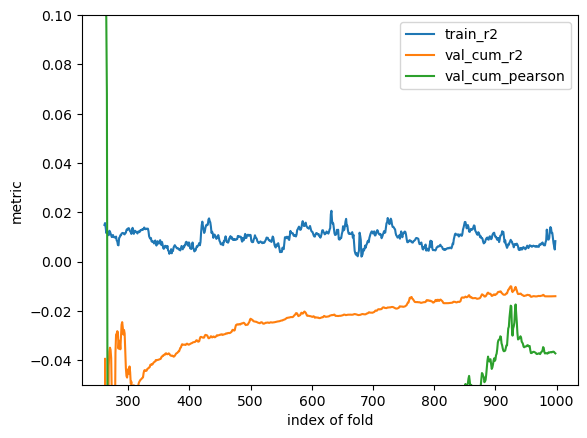

In [49]:
plt.figure(1)
plot_performance(performance_cv, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.show()

In [8]:
from qids_lib import QIDS
qids = QIDS(path_prefix='../../')

In [50]:
from pipeline.backtest import evaluation_for_submission

model = SimpleModel(feature, demean=False)
train_lookback = 60
performance_eval = evaluation_for_submission(model, ds, qids, lookback_window=train_lookback)

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 6.3993e-03
The ending score for metric test_cum_r2 is: -1.1974e-02
The ending score for metric test_cum_pearson is: -2.9349e-02


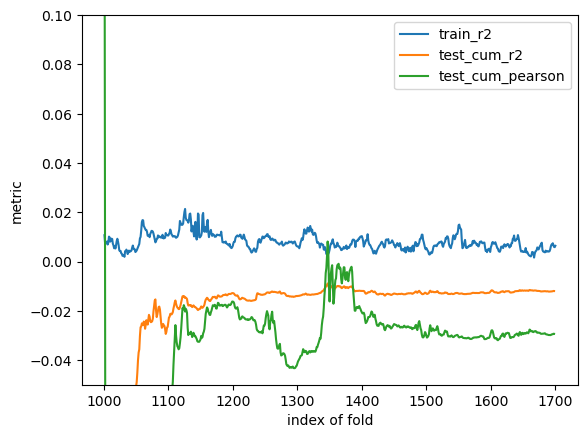

In [51]:
plt.figure(1)
plot_performance(performance_eval, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plt.show()